# DIGITAL IMAGE PROCESSING IN THE SPACE-FREQUENCY DOMAIN

## IMAGE FUSION 

**@author: Salvador Gabarda**

**salvador@optica.csic.es**

This is a customized code for digital image fusion. Part of the code relies on an additional customized software named "sgtools.py". Details and examples of this image fusion algorithm may be found in [1]


https://www.spiedigitallibrary.org/journals/Optical-Engineering/volume-44/issue-4/047001/Multifocus-image-fusion-through-pseudo-Wigner-distribution/10.1117/1.1881412.short

[1] Gabarda, Salvador, and Cristóbal-Perez, Gabriel. "Multifocus image fusion through pseudo-Wigner distribution." Optical Engineering 44.4 (2005): 047001.


*Created on Mar 24 2018, reviewed Dec 27 2019*


### 1. The code

Required modules

Customized code from  *sgtools.py*

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.fftpack import fft, ifft
import math
from scipy import signal
%matplotlib inline
#import sys  
#sys.path.insert(0, 'C:/Users/User/Python/External')
import sgtools as sgt

import os
os.path
cwd = os.getcwd()
print(cwd)

/home/nbuser/library


### 2. Input test images

Any number of images can be uploaded with the following constraints:

1) All the images have to be written in *png* format and with the same $M \times N$ shape

2) Image names have to  follow the pattern *topic.xxx.png* , where *topic* is a common name to all the images related in the test and   *xxx* represents a sequence of numbers  $001, 002, ... , 999$ . The sequence $000$ is kept for the groundtruth image, in the case that it is available.

The following example uses images *clock.001.png* and *clock.002.png*

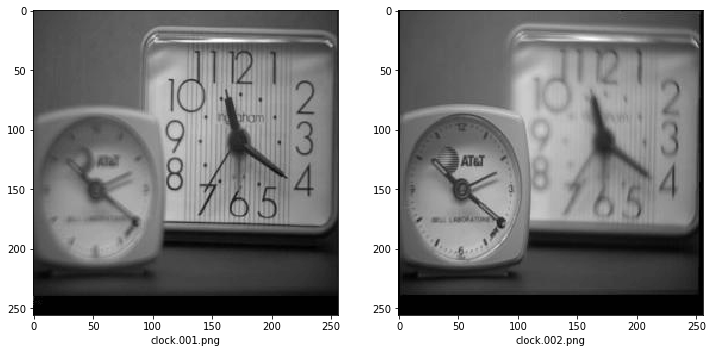

In [2]:
number = 2 # number of test images
topic = 'clock' # topic name of all images
R = number
name = topic
subfolder = ''
  

fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 1

for i in range(1, columns*rows +1):
    if i<10:
        series = "00"
    elif (i>=10 and i <100):
        series = "0"
    elif (i>=100 and  i<1000):
        series = "" 
    name =  topic + '.' + series + str(i) + '.png'
    image2show = sgt.input_test_image(subfolder,name)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image2show,cmap='gray')
    plt.xlabel(name)
plt.show()

### 3. Worst case of input images

Images $clock.001.png$ and $clock.002.png$ are blurred with a filter and then averaged to get a worst case of both input images


processing image  clock.001.png
processing image  clock.002.png


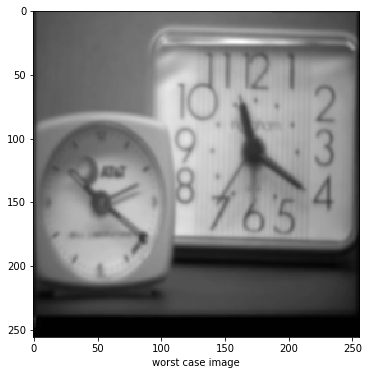

In [4]:
# initial conditions
number = 2 # number of test images
topic = 'clock' # topic name of all images
R = number
name = topic
subfolder = ''

mask = np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])
mask = (1/256)*mask

for i in range(1,R+1):
    if i<10:
        series = "00"
    elif (i>=10 and i <100):
        series = "0"
    elif (i>=100 and  i<1000):
        series = "" 
    # input test image
    image_name =  name + '.' + series + str(i) + '.png'
    print("processing image ",image_name)
    test_image = sgt.input_test_image(subfolder,image_name)
    if i == 1:
        img_shape = np.shape(test_image)
        rows = img_shape[0]
        columns = img_shape[1]
        stack = np.zeros(((R,rows,columns)))
        blur = np.zeros(((R,rows,columns)))
        stack[0,:,:] = test_image
        blur[0,:,:]= signal.convolve2d(test_image, mask, boundary='symm', mode='same')
    else:
        stack[i-1,:,:] = test_image
        blur[i-1,:,:]= signal.convolve2d(test_image, mask, boundary='symm', mode='same')
        
blur = np.sum(blur,0)
blur = (1/R)*blur

# convert image to regular gray levels 
blur =np.uint8(blur)

# show blurred image
plt.figure(figsize =(6,6))
plt.imshow(blur, cmap='gray')
plt.xlabel("worst case image")
plt.show()

### 4. Wigner distribution of input images and worst case

The wigner distributions of images $clock.001.png$, $clock.002.png$ and "worst case image" are computed and the pixelwise norm between input images and the worst case are used to build a decision map which indicate from where the pixels should be chosen to get a sharp copy of the subject.

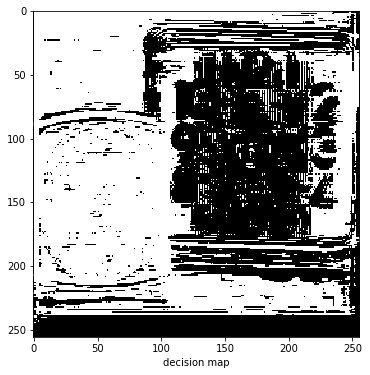

In [5]:
seq_length = 9
angle = 0

wigner_blur = sgt.layer_wigner_distribution(blur,seq_length,angle)
wigner_stack = np.zeros(((R,rows,columns)))
norm = np.zeros(((R,rows,columns)))
for i in range(R):
    stack_copy = np.copy(stack[i,:,:])
    wigner = sgt.layer_wigner_distribution(stack_copy,seq_length,angle)
    diff = np.subtract(wigner_blur,wigner)
    diff = np.square(diff)
    norm[i,:,:] = np.sum(diff,axis = 0)
mapa = np.argmax(norm,0)

# show decision map
plt.figure(figsize =(6,6))
plt.imshow(mapa, cmap='gray')
plt.xlabel("decision map")
plt.show()

### 5. Fusion

We use the decision map to  select the right pixels from $clock.001.png$, $clock.002.png$ images and build a sharp image of the subject. 

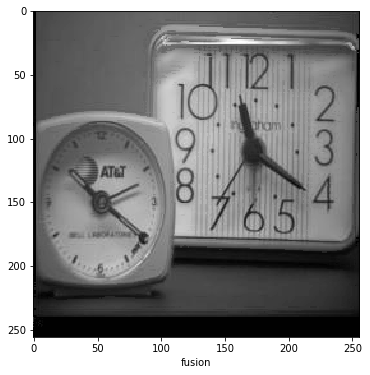

In [6]:
fusion = np.zeros((rows,columns))
for i in range(R):
    stack_copy = np.copy(stack[i,:,:])
    factor = mapa == i
    fusion = fusion + np.multiply(factor,stack_copy)
    
# show fusion
plt.figure(figsize =(6,6))
plt.imshow(fusion, cmap='gray')
plt.xlabel("fusion")
plt.show()
    

### 6. Additional examples 

A second example is shown. First we take a look to the test images (*mermaid.001.png, mermaid.002.png*) 

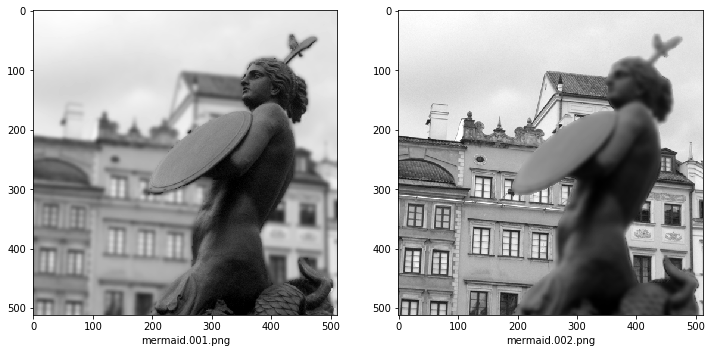

In [8]:
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 1
topic = 'mermaid' # topic name of all images
R = number
name = topic
subfolder = ''

for i in range(1, columns*rows +1):
    if i<10:
        series = "00"
    elif (i>=10 and i <100):
        series = "0"
    elif (i>=100 and  i<1000):
        series = "" 
    name =  topic + '.' + series + str(i) + '.png'
    image2show = sgt.input_test_image(subfolder,name)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image2show,cmap='gray')
    plt.xlabel(name)
plt.show()

An then the whole process can be realized through a function called *mapfusion* included in *sgtools.py*.

processing image  mermaid.001.png
processing image  mermaid.002.png


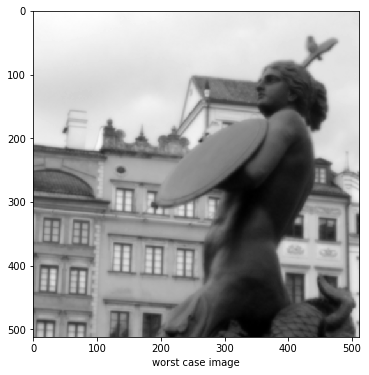

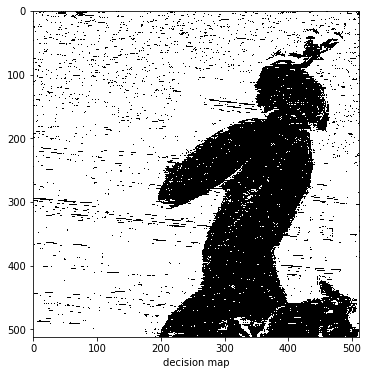

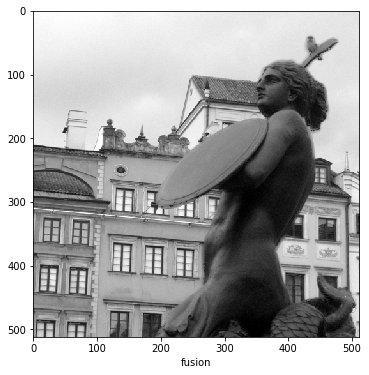

In [9]:
subfolder = ''
topic = "mermaid"
number = 2
mode = 1
blur,mapa,fusion = sgt.mapfusion(subfolder,topic,number,mode)

This is another example with images *arch.001.png* and *arch.002.png* 

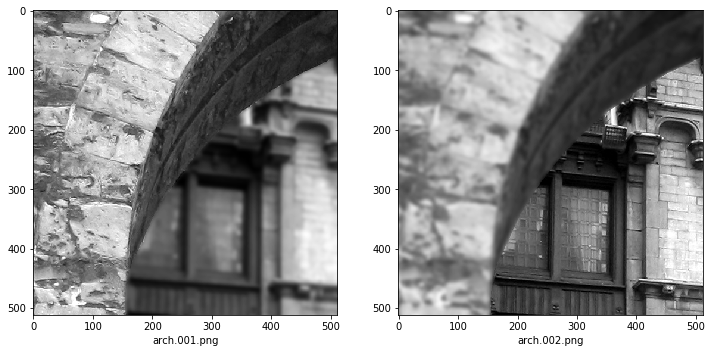

In [10]:
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 1
topic = 'arch' # topic name of all images
R = number
name = topic
subfolder = ''
  
for i in range(1, columns*rows +1):
    if i<10:
        series = "00"
    elif (i>=10 and i <100):
        series = "0"
    elif (i>=100 and  i<1000):
        series = "" 
    name =  topic + '.' + series + str(i) + '.png'
    image2show = sgt.input_test_image(subfolder,name)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image2show,cmap='gray')
    plt.xlabel(name)
plt.show()

processing image  arch.001.png
processing image  arch.002.png


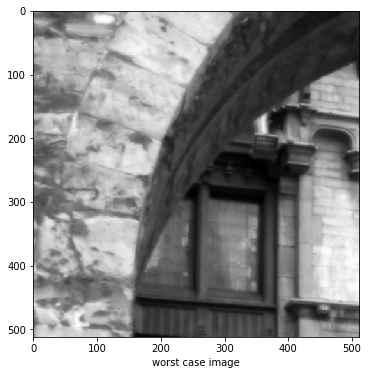

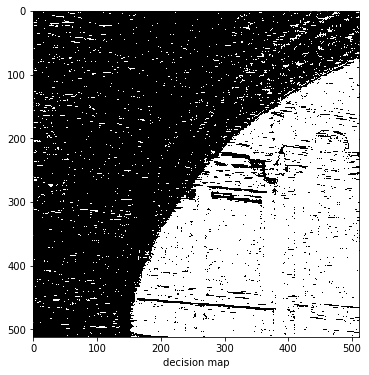

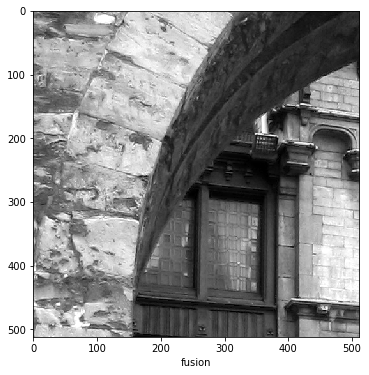

In [11]:
subfolder = ""
topic = "arch"
number = 2
mode = 1
blur,map,fusion = sgt.mapfusion(subfolder,topic,number,mode)

### Save the fusion as image

In [12]:
fusion = np.uint8(fusion)
from matplotlib import cm
mpimg.imsave('fusion.png',fusion,cmap = cm.gray)

### 7. Alternative fusion method

One step forward is the use of a fusion method based on the Rényi entropy calculated upon a local 1-D pseudo-Wigner distribution (PWD) of the image. The fused image is obtained after the application of a Rényi entropy measure to the point-wise PWD of the images. The Rényi measure allow us to individually identify, from an entropic criterion, what
pixels have a higher amount of information among the given input images. Additional information about the use of 
entropy for image fusion may be found in [2].

https://www.spiedigitallibrary.org/conference-proceedings-of-spie/5910/59100E/The-Renyi-entropy-as-a-decision-measure-for-a-pseudo/10.1117/12.617269.short?SSO=1

[2] Gabarda, Salvador, and Gabriel Cristobal. "The Renyi entropy as a decision measure for a pseudo-Wigner distribution image fusion framework." Advanced Signal Processing Algorithms, Architectures, and Implementations XV. Vol. 5910. International Society for Optics and Photonics, 2005.

### 8. Example of alternative fusion method

We apply a method based on entropy [2] (*mixfusion*) to one of the above examples. The algorithm calculates the entropy of
the input images at pixel level and generates a decision map indicating the image that shows the maximum entropy at pixel level. These values indicate the pixel positions to build the fusion image. In the following example, image 001 is related to  black pixels in the map and image 002 is related to the white ones.    


processing image  mermaid.001.png
processing image  mermaid.002.png


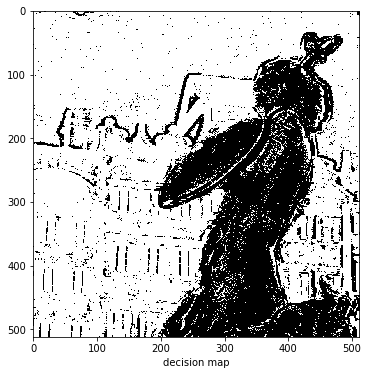

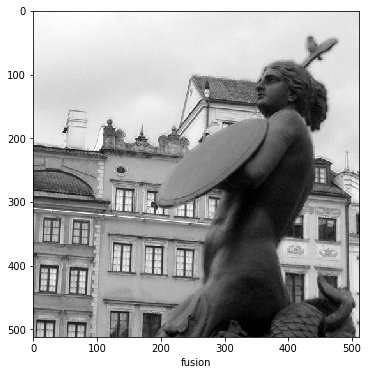

In [13]:
subfolder = ""
topic = "mermaid"
number = 2
mode = 1
entropy,mapa,fusion = sgt.maxentropyfusion(subfolder,topic,number,mode)